In [2]:
# Block to standardize local and Colab.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    # Configure kaggle
    files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # Download the workshop repo and change to its directory
    # For now edit the username/password. This requirement will be removed when the repo is made public.
    !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git ../repo
    os.chdir('../repo')
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    IN_COLAB = False    

Saving kaggle.json to kaggle.json
fatal: destination path '../repo' already exists and is not an empty directory.


In [3]:
# Download faces_basic if we don't already have it.
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()
    

100% 2.24G/2.24G [00:36<00:00, 16.6MB/s]
100% 2.24G/2.24G [00:36<00:00, 65.7MB/s]
Finished downloading. Now extracting contents...


Let's say we have a trivial system of linear equations:

\begin{array}{lcl}
1m + 1n & = & 35\\
2m + 4n & = & 94
\end{array}

This system can be represented in matrix notation, where

$A=\begin{bmatrix}
1 & 1 \\
2 & 4 \\
\end{bmatrix}, 
x=\begin{bmatrix}
m \\
n \\
\end{bmatrix}, 
b=\begin{bmatrix}
35 \\
94 \\
\end{bmatrix}$

$\begin{bmatrix}
1 & 1 \\
2 & 4 \\
\end{bmatrix}
\begin{bmatrix}
m \\
n \\
\end{bmatrix}
=
\begin{bmatrix}
35 \\
94 \\
\end{bmatrix}$

$Ax=b$

Let's let x and b be matrices:

$AX=B$

These variables can take on different meanings depending on the
experiment formulation and type of analysis. This can be confusing.
Instead, let's be consistent about how the variable names map to our data, and then
we will shuffle the equation around as needed.

X: Known brain signals, often reshaped into a matrix.

(~~B~~)Y: Known labels (intention, behaviour, experimental conditions)

A: The unknown variable.

| Type | Equation .....| X dims | Y | A (solve for) | 
|---|---|---|---|---| 
|BCI|$XA=Y$|trials, time, space|Intent/Behav.|Decoder|
|Stats|$YA=X$|trials, time, space|Task Conds.|Encoder|
|BCI|$XA=Y$|trials, space|Intent/Behav.|Spatial filter|
|Stats|$YA=X$|trials, space|Task Conds.|Spatial patterns|

![patterns Vs filters](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/patterns_v_filters.jpg?raw=1)

---
**Bonus** 

$\begin{array}\\
XA&=&Y \\
XAA^{-1}&=&YA^{-1} \\
X&=&YA^{-1}\end{array}$

Or, in other words, the Decoder matrix is the inverse of the Encoder matrix.
See [Haufe et al., NeuroImage 2014](https://www.sciencedirect.com/science/article/pii/S1053811913010914)

---

Let's solve for A.

$\begin{array}\\
XA&=&Y \\
X^{-1}XA&=&X^{-1}Y \\
A&=&X^{-1}Y\end{array}$


In [0]:
import numpy as np

X = np.array([[1, 1,], [2, 4]])
Y = np.array([[35], [94]])
X_inv = np.linalg.inv(X)
A = X_inv @ Y  # or np.matmul(X_inv, Y)

print("1*{} + 1*{} = 35; {}".format(
    A[0, 0], A[1, 0], 1 * A[0, 0] + 1 * A[1, 0] == 35))
print("2*{} + 4*{} = 94; {}".format(
    A[0, 0], A[1, 0], 2 * A[0, 0] + 4 * A[1, 0] == 94))

1*23.0 + 1*12.0 = 35; True
2*23.0 + 4*12.0 = 94; True


The majority of brain signal analysis is getting the data into these variables (X, Y),
and then solving this equation, often with different constraints imposed on the solution.

Let's look at one of the most basic examples...

## (Fisher's) Linear Discriminant Analysis (LDA)

Using the BCI formulation (XA=Y), find the transformation matrix (A) that
maximizes the between-class variance in X relative to the within-class variance in X,
where "class" is encoded in Y.
 

In [28]:
# Load data from one participant.
SUB_ID = 'de'  # 'de', 'ca', 'fp', 'ha' ~ 97%; 'ap', 'ja' 90-92%; 'jt', 'rn': 80%
from data.utils.fileio import from_neuropype_h5
test_file = datadir / 'converted' / 'faces_basic' / (SUB_ID + '_bp.h5')
chunks = from_neuropype_h5(test_file)
chunk_names = [_[0] for _ in chunks]
chunk = chunks[chunk_names.index('signals')][1]
ax_types = [_['type'] for _ in chunk['axes']]
instance_axis = chunk['axes'][ax_types.index('instance')]
n_trials = len(instance_axis['data'])
X = chunk['data'].reshape((n_trials, -1))  # 603 trials x 527 features
Y = instance_axis['data']['Marker'].values
print(X.shape, Y.shape)

(603, 986) (603,)


For a full step-by-step example of doing LDA from scratch, try [this online example](https://www.python-course.eu/linear_discriminant_analysis.php).

Here, let's try to classify these data using simple / shallow machine learning using the excellent scikit-learn Python package.

https://scikit-learn.org/stable/modules/lda_qda.html

In [29]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10)

y_preds = []
y_true = []
for trn, tst in splitter.split(X, Y):
    lda.fit(X[trn], Y[trn])
    y_preds.append(lda.predict(X[tst]))
    y_true.append(Y[tst])

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("3-class accuracy: {}".format(pcnt_corr))

3-class accuracy: 98.00995024875621


### Compare to baseline
While this accuracy is undoubtedly good, it's hard to know how good without knowing what
we should expect for baseline accuracy. There are a couple ways to do this.
First, we will shuffle our labels and try again.
Second, we will simply say that every trial is ISI and see how we do.

In [0]:
shuff_preds = []
y_shuff = []
Y_shuff = np.copy(Y)
np.random.shuffle(Y_shuff)
for trn, tst in splitter.split(X, Y_shuff):
    lda.fit(X[trn], Y_shuff[trn])
    shuff_preds.append(lda.predict(X[tst]))
    y_shuff.append(Y[tst])

shuff_preds = np.hstack(shuff_preds)
y_shuff = np.hstack(y_shuff)

pcnt_corr = 100 * np.sum(shuff_preds == y_shuff) / len(y_preds)
print("3-class shuffled accuracy: {}".format(pcnt_corr))

y_always_ISI = np.array(['ISI']*len(y_shuff))
pcnt_corr = 100 * np.sum(y_always_ISI == y_true) / len(y_true)
print("Always-ISI accuracy: {}".format(pcnt_corr))

3-class shuffled accuracy: 40.46434494195688
Always-ISI accuracy: 50.24875621890547


So the best we can do with random guessing is in the 35-40% range.
The best we can do by guessing always ISI is 50% (note: this is technically "better than chance",
so "better than chance" is meaningless!)

### Plot result
Let's plot the results in a Confusion Matrix to take a closer look.

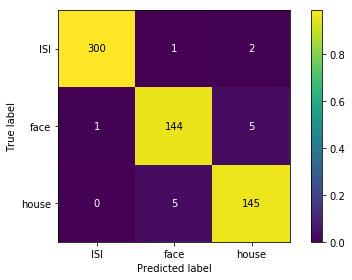

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

classes = unique_labels(y_true, y_preds)
cm = confusion_matrix(y_true, y_preds)
cm_int = np.copy(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      # ... and label them with the respective list entries
      xticklabels=classes, yticklabels=classes,
      ylabel='True label',
      xlabel='Predicted label')

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_int[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "white")
fig.tight_layout()

This is a pretty good result. But remember, we did some significant preprocessing based on years
of expertise working with these types of data.
Also, we used ~540 within-session trials to train the classifier.
This classifier will not generalize well to another patient,
and maybe not even to another session with the same patient.
No one wants to spend 540 trials training a keyboard before they start typing every day.

### Visualize model
We want to visualize the best possible model for these data, without worrying about whether or not it generalizes to outside data. So let's train the model again using all trials, and start by visualizing the LDA components.

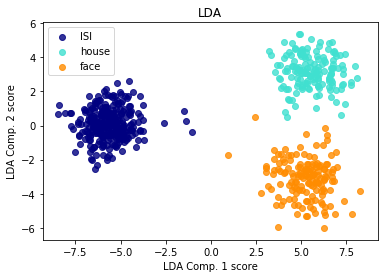

In [0]:
lda = LDA(shrinkage='auto', solver='eigen')
lda.fit(X, Y)

# Transform data with model to get lower-dimensional projections that separate classes
comps = lda.transform(X)

for color, label in zip(['navy', 'turquoise', 'darkorange'], ['ISI', 'house', 'face']):
    plt.scatter(comps[Y == label, 0], comps[Y == label, 1],
                alpha=.8, color=color, label=label)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('LDA')
plt.xlabel('LDA Comp. 1 score')
plt.ylabel('LDA Comp. 2 score')
plt.show()

We see that the first component separates ISI from stimulus conditions,
and the second component separates house from face.
So let's visualize the scalings so we can get an idea for which channels and samples are important for each component.

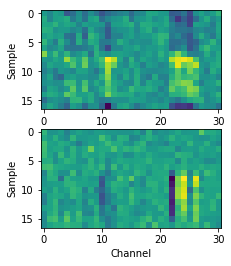

In [0]:
for comp_ix in range(2):
  decoder = lda.scalings_[:, comp_ix].reshape(chunk['data'].shape[1:])
  plt.subplot(2, 1, comp_ix + 1)
  plt.imshow(decoder)
  plt.xlabel('Channel')
  plt.ylabel('Sample')
plt.show()

### Regularization
In the call to the LinearDiscriminantAnalysis, we supplied an argument `shrinkage=auto`. The parameter is explained [here](https://scikit-learn.org/stable/modules/lda_qda.html#shrinkage) and the difference with and without shrinkage is ([demonstrated here](https://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py)).

Shrinkage is a form of regularization.

In [0]:
# TODO: Talk about regularization.